# HyperParams

In [1]:
EPOCHS = 40
learning_rate = 3e-4
embed_size = 128
batch_size = 32
hidden_size = 256
n_layers = 2

# Data

In [2]:
from collections import Counter
import torch.utils.data as data
from torchtext.vocab import vocab as build_vocab
from torchtext.data.utils import get_tokenizer
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import re
import os

In [3]:
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

In [4]:
tqdm.pandas() # merging tqdm with pandas for better progress-bars while looping

In [5]:
data_dir = "/home/krish/Datasets/IMDB-Pos-vs-Neg/"
splits = list(map(lambda csv: os.path.join(data_dir, csv), os.listdir(data_dir)))

df = pd.concat(list(map(pd.read_csv, splits)), ignore_index=True)

In [6]:
df.head()

,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0


In [7]:
def clean_text(text):
    text = text.lower()
    text = text.replace("<br />", "")
    text = re.sub(r'[^\w\s]', "", text)
    return text

df['text'] = df['text'].map(clean_text) # Cleaning the text
df['text'] = df['text'].progress_map(tokenizer) # Splitting Words

100%|███████████████████████████████████| 50000/50000 [00:21<00:00, 2295.58it/s]


In [8]:
counter = Counter()
for text in tqdm(df['text']):
    counter.update(text)
    
vocab = build_vocab(counter, min_freq=2)

## Speacial Tokens 
special_tokens = ('<PAD>', '<UNK>')
for i, tok in enumerate(special_tokens): vocab.insert_token(tok, i)
vocab.set_default_index(special_tokens.index("<UNK>"))

df['text'] = df['text'].map(vocab)
vocab_size = len(vocab)

100%|██████████████████████████████████| 50000/50000 [00:01<00:00, 35823.44it/s]


<AxesSubplot:ylabel='Frequency'>

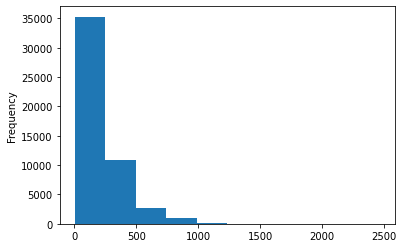

In [9]:
text_lens = df['text'].map(lambda s: len(s))
text_lens.plot.hist()

In [10]:
df = df[text_lens < 500 ]
text_lens = text_lens[text_lens < 500]

df = df[text_lens > 50]
text_lens = text_lens[text_lens > 50]

<AxesSubplot:ylabel='Frequency'>

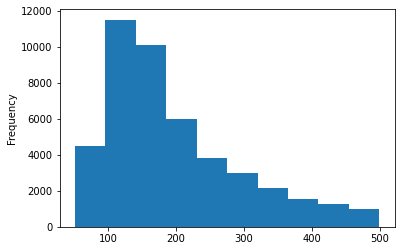

In [11]:
text_lens = df['text'].map(lambda s: len(s))
text_lens.plot.hist()

In [12]:
seq_len = 250

def padd_and_truncate(text):
    text = text[:seq_len]
    
    padd_size = seq_len - len(text)
    padding = [0] * padd_size
    
    return padding + text

df['text'] = df['text'].map(padd_and_truncate)

assert (df['text'].map(lambda s: len(s)) == seq_len).all()

In [13]:
reviews = torch.tensor(df['text'].to_list())
labels = torch.tensor(df['label'].to_list())

dataset = data.TensorDataset(reviews, labels)
dataset = data.DataLoader(dataset, batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=True)

# Model

In [14]:
import torch.nn as nn
import torch

In [15]:
class Model(nn.Module):
    def __init__(self, hidden_size, embed_size, vocab_size, n_layers, dropout = 0.5, output_size = 1):
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True, num_layers=n_layers, dropout=dropout)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(0.3)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, review):
        batch_size = review.size(0)
        
        embeded = self.embed(review) # (batch_size, seq_len, embed_size)
    
        lstm_out, _ = self.lstm(embeded) # (batch_size, seq_len, hidden_size)
        
        lstm_out = lstm_out.reshape(-1, hidden_size) # (batch_size * seq_len, hidden_size)
        
        linear = self.linear(lstm_out) # (batch_size * seq_len, 1) (output_size=1)
        
        linear = linear.reshape(batch_size, -1) # (batch_size, seq_len)
        
        output = linear[:,-1:] # (batch_size, 1) (taking last item on seq_len dim)
        
        output = self.sigmoid(output) # sigmoid
        
        return output
        
                
net = Model(hidden_size, embed_size, vocab_size, n_layers)

# Trainning

In [16]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

In [17]:
!rm -rf runs
writer = SummaryWriter("runs/")
global_step = 1

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = net.to(device)

In [19]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [20]:
for epoch in range(EPOCHS):
    losses = []
    with tqdm(dataset, desc=f"EPOCH {epoch+1}") as pbar:
        for review, y in pbar:
            review = review.to(device)
            Y = net(review)
            loss = criterion(Y.squeeze(1), y.float().to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item())
            losses.append(loss.item())
            writer.add_scalar("loss", loss.item(), global_step=global_step)
            global_step += 1

EPOCH 40: 100%|███████████████| 1404/1404 [03:01<00:00,  7.73it/s, loss=4.96e-5]


# Evaluating

In [21]:
import matplotlib.pyplot as plt

In [145]:
review, y = next(iter(dataset))

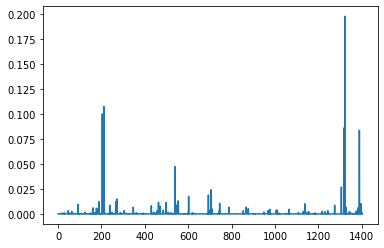

In [23]:
plt.plot(losses)

In [158]:
print(' '.join([vocab.get_itos()[i] for i in review[0]]))
print("")
print("Positive" if y[0] > 0.5 else "Negative")

an excellent cast who do their best with an awful script inept direction and some of the worst score that i have ever heard more tv movie of the week than serious drama which is sad when one considers that the source material is very serious and very real the film makers decided that instead of building drama and character it was better to just show the most graphic and violent bits and hope that the audience would be shocked into sympathy and caring in my opinion one the most blatant forms of cut and paste film adapting

Negative


In [157]:
review = """an excellent cast who do their best with an awful script inept direction and some of the worst score that i have ever heard more tv movie of the week than serious drama which is sad when one considers that the source material is very serious and very real the film makers decided that instead of building drama and character it was better to just show the most graphic and violent bits and hope that the audience would be shocked into sympathy and caring in my opinion one the most blatant forms of cut and paste film adapting"""

review = torch.tensor(vocab(tokenizer(review)), device=device).view(1, -1)

with torch.no_grad():
    sentiment = net(review).item()
    if sentiment > 0.5:
        print(f"Positive {(sentiment*100):.3f}%")
    else:
        print(f"Negative {((1-sentiment)*100):.3f}%")

Negative 99.929%


In [60]:
torch.save(net.state_dict(), "IMDB-Pos-vs-Neg.pth")

# Thank You 🙏️